# Tanzania water pumps project : Machine Learning

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, f1_score, log_loss
from scipy.stats import kendalltau, spearmanr
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
clean_df = pd.read_csv('../Data/Clean_DF.csv', index_col='id')

In [3]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 23 columns):
amount_tsh               59400 non-null float64
funder                   59400 non-null object
gps_height               59400 non-null int64
installer                59400 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
basin                    59400 non-null object
region                   59400 non-null object
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
public_meeting           59400 non-null bool
permit                   59400 non-null bool
construction_year        59400 non-null float64
extraction_type_class    59400 non-null object
management               59400 non-null object
payment                  59400 non-null object
quality_group            59400 non-null obje

## Categorize columns

In [4]:
X = pd.DataFrame()
# These categories are not ordered
col_to_cat=['funder','installer','basin','region','district_code','lga','ward',
            'extraction_type_class','management','source_type','waterpoint_type_group']
for col in col_to_cat:
    X[col] = clean_df[col].astype('category').cat.codes

# These categories are ordered
payment_type = pd.CategoricalDtype(categories=['other','never pay','pay when scheme fails',
                                               'pay annually','pay monthly','pay per bucket'],
                                   ordered=True)
X['payment'] = clean_df['payment'].astype(payment_type).cat.codes

quality_group_type = pd.CategoricalDtype(categories=['unknown','fluoride','salty','colored',
                                                     'milky','good'], ordered=True)
X['quality_group'] = clean_df['quality_group'].astype(quality_group_type).cat.codes

quantity_type = pd.CategoricalDtype(categories=['unknown','dry','insufficient','seasonal',
                                                'enough'], ordered=True)
X['quantity'] = clean_df['quantity'].astype(quantity_type).cat.codes

In [5]:
X = pd.concat([X, clean_df[['public_meeting','permit']]], axis='columns')

## Scale numeric columns

In [6]:
col_numeric = ['amount_tsh','gps_height','longitude','latitude','population','construction_year']

In [7]:
# Scale columns using MinMax scaler to have only positive values
s = MinMaxScaler()
scaled_array = s.fit_transform(clean_df[col_numeric].astype(float))
scaled_df = pd.DataFrame(scaled_array, index=clean_df.index, columns=col_numeric)

XS = pd.concat([X, scaled_df], axis='columns')

In [8]:
# X is not scaled
X = pd.concat([X, clean_df[col_numeric]], axis='columns')

In [9]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 22 columns):
funder                   59400 non-null int8
installer                59400 non-null int8
basin                    59400 non-null int8
region                   59400 non-null int8
district_code            59400 non-null int8
lga                      59400 non-null int8
ward                     59400 non-null int8
extraction_type_class    59400 non-null int8
management               59400 non-null int8
source_type              59400 non-null int8
waterpoint_type_group    59400 non-null int8
payment                  59400 non-null int8
quality_group            59400 non-null int8
quantity                 59400 non-null int8
public_meeting           59400 non-null bool
permit                   59400 non-null bool
amount_tsh               59400 non-null float64
gps_height               59400 non-null int64
longitude                59400 non-null float64
latitude                 

In [10]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
funder,59400.0,50.852559,26.907972,0.000000,27.000000,61.000000,66.000000,100.000000
installer,59400.0,44.419680,24.918253,0.000000,27.000000,33.000000,67.000000,99.000000
basin,59400.0,4.077172,2.473082,0.000000,2.000000,4.000000,6.000000,8.000000
region,59400.0,9.835606,5.936892,0.000000,4.000000,10.000000,15.000000,20.000000
district_code,59400.0,3.867424,2.992263,0.000000,2.000000,3.000000,5.000000,19.000000
lga,59400.0,60.039882,35.244499,0.000000,30.000000,60.000000,91.000000,124.000000
ward,59400.0,89.950303,24.057736,0.000000,100.000000,100.000000,100.000000,100.000000
extraction_type_class,59400.0,1.264663,1.626676,0.000000,0.000000,1.000000,2.000000,6.000000
management,59400.0,6.329630,1.917857,0.000000,6.000000,6.000000,6.000000,10.000000
source_type,59400.0,3.970556,2.191798,0.000000,3.000000,5.000000,6.000000,6.000000


In [11]:
XS.describe().T

,count,mean,std,min,25%,50%,75%,max
funder,59400.0,50.852559,26.907972,0.0,27.000000,61.000000,66.000000,100.0
installer,59400.0,44.419680,24.918253,0.0,27.000000,33.000000,67.000000,99.0
basin,59400.0,4.077172,2.473082,0.0,2.000000,4.000000,6.000000,8.0
region,59400.0,9.835606,5.936892,0.0,4.000000,10.000000,15.000000,20.0
district_code,59400.0,3.867424,2.992263,0.0,2.000000,3.000000,5.000000,19.0
lga,59400.0,60.039882,35.244499,0.0,30.000000,60.000000,91.000000,124.0
ward,59400.0,89.950303,24.057736,0.0,100.000000,100.000000,100.000000,100.0
extraction_type_class,59400.0,1.264663,1.626676,0.0,0.000000,1.000000,2.000000,6.0
management,59400.0,6.329630,1.917857,0.0,6.000000,6.000000,6.000000,10.0
source_type,59400.0,3.970556,2.191798,0.0,3.000000,5.000000,6.000000,6.0


In [12]:
# Label
y = pd.Series()
labels = ['non functional','functional needs repair', 'functional']
status_group_type = pd.CategoricalDtype(categories=labels, ordered=True)
y = clean_df['status_group'].astype(status_group_type).cat.codes

## Separate training from hold out data

Split training and hold out data with stratify because the labels are not balanced.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [14]:
XS_train, XS_test, ys_train, ys_test = train_test_split(XS, y, test_size=0.2, stratify=y)

## Calculate metrics for perfect model

This function computes the metrics and stores them to plot the models comparison.

In [15]:
def scores(y_test,y_pred,name=None):
    cm = confusion_matrix(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    kt = kendalltau(y_test, y_pred)
    sp = spearmanr(y_test, y_pred)
    print('Confusion matrix:')
    print(cm)
    print('\nF1 score: ', f1)
    print('\n', kt)
    print('\n', sp)
    if name is not None:
        scores_df.loc['F1 score', name] = f1
        s,p = kt
        scores_df.loc['KendallTau', name] = s
        s,p = sp
        scores_df.loc['Spearman', name] = s
        recall_df.loc['Non Functional',name] = cm[0,0] / cm[0,:].sum()
        recall_df.loc['Functional needs repair',name] = cm[1,1] / cm[1,:].sum()
        recall_df.loc['Functional',name] = cm[2,2] / cm[2,:].sum()
        precision_df.loc['Non Functional',name] = cm[0,0] / cm[:,0].sum()
        precision_df.loc['Functional needs repair',name] = cm[1,1] / cm[:,1].sum()
        precision_df.loc['Functional',name] = cm[2,2] / cm[:,2].sum()
    return

In [16]:
scores_df = pd.DataFrame(index=['F1 score','KendallTau','Spearman'])
recall_df = pd.DataFrame(index=['Non Functional','Functional needs repair','Functional'])
precision_df = pd.DataFrame(index=['Non Functional','Functional needs repair','Functional'])

In [17]:
print('Scores for Perfect Model:\n')
scores(y_test,y_test,'Perfect')

Scores for Perfect Model:

Confusion matrix:
[[4565    0    0]
 [   0  863    0]
 [   0    0 6452]]

F1 score:  1.0

 KendalltauResult(correlation=1.0, pvalue=0.0)

 SpearmanrResult(correlation=1.0, pvalue=0.0)


Kendall Tau is a measure of the correspondence between 2 rankings. It's a good measure for this problem because the labels are ordered.

## Calculate metrics for dummy model

A dummy model would be to give the label a random value according to the proportions in the sample.

In [18]:
labels_count = y_test.value_counts().sort_index()
y_pred_s = np.ones_like(y_test, dtype=int)
y_pred_s[:labels_count[0]] = 0
y_pred_s[-labels_count[2]:] = 2
np.random.shuffle(y_pred_s)

The probabilities for each label are the proportions of each label in the sample.

In [19]:
y_pred_proba_s = np.empty((len(y_test),3),dtype=float)
for i in range (0,3):
    y_pred_proba_s[:,i] = labels_count[i]/len(y_test)

In [20]:
print('Scores for Dummy Model:\n')
scores(y_test, y_pred_s, 'Dummy')

Scores for Dummy Model:

Confusion matrix:
[[1760  324 2481]
 [ 327   66  470]
 [2478  473 3501]]

F1 score:  0.4484006734006734

 KendalltauResult(correlation=-2.6539325132681867e-05, pvalue=0.9975579831195174)

 SpearmanrResult(correlation=-2.7653077289063652e-05, pvalue=0.9975953858889406)


## Calculate metrics for different models

### Linear Logistic Regression

This is a simple linear model. We use dataset where numeric columns are scaled for this model.

In [21]:
lr = OneVsRestClassifier(LogisticRegression(random_state=14, multi_class='ovr',
                                            class_weight='balanced', solver='liblinear'))

In [22]:
lr.fit(XS_train, ys_train)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=None, penalty='l2', random_state=14,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=None)

In [23]:
y_pred_lr = lr.predict(XS_test)
y_pred_proba_lr = lr.predict_proba(XS_test)
print('Scores for logistic regression:\n')
scores(ys_test, y_pred_lr, 'Logistic Regression')

Scores for logistic regression:

Confusion matrix:
[[2959  583 1023]
 [ 225  278  360]
 [1375 1072 4005]]

F1 score:  0.63109991112411

 KendalltauResult(correlation=0.3993970809732616, pvalue=0.0)

 SpearmanrResult(correlation=0.4270794026262268, pvalue=0.0)


The results are better than those of the dummy model. Most of the ‘functional needs repair’ and a lot of ‘functional’ are misclassified.

It seems the linear model is not so good for this project.

### SVM

This model is more complex and needs more computation. But because it finds a separating hyperplane, it could be good to predict the ‘functional needs repair’ class that is in between.
We use scaled numeric values for this model


In [24]:
svm = OneVsRestClassifier(SVC(random_state=14, class_weight='balanced', 
                              decision_function_shape='ovr', gamma='scale'))

In [25]:
# use scaled XS for SVM
svm.fit(XS_train, ys_train)

OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=14, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=None)

In [26]:
y_pred_svm = svm.predict(XS_test)
print('Scores for SVM:\n')
scores(ys_test, y_pred_svm, 'SVM')

Scores for SVM:

Confusion matrix:
[[3034  614  917]
 [ 144  469  250]
 [1025 1084 4343]]

F1 score:  0.6827804286955201

 KendalltauResult(correlation=0.4834483663472558, pvalue=0.0)

 SpearmanrResult(correlation=0.5123036942010897, pvalue=0.0)


More labels are well classified, and all the metrics are better.

### Random Forest

We use non-scaled numeric values because Decision Trees are not based on distance, hence are not sensitive to features with different scales.

In [27]:
rf = OneVsRestClassifier(RandomForestClassifier(random_state=14, n_estimators=10))

In [28]:
rf.fit(X_train, y_train)

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=14, verbose=0, warm_start=False),
          n_jobs=None)

In [29]:
y_pred_rf = rf.predict(X_test)
y_pred_proba_rf = rf.predict_proba(X_test)

In [30]:
print('Scores for Random Forest:\n')
scores(y_test, y_pred_rf, 'Random Forest')

Scores for Random Forest:

Confusion matrix:
[[3488   81  996]
 [ 115  306  442]
 [ 608  193 5651]]

F1 score:  0.7895515817798843

 KendalltauResult(correlation=0.6391612181152956, pvalue=0.0)

 SpearmanrResult(correlation=0.6580384569292568, pvalue=0.0)


‘non functional’ and ‘functional’ are predicted more accurately, but the random forest has difficulties predicting the ‘functional needs repair’ class.

However, the metrics are better.


### K Neighbors

We use scaled numeric values for this model.

In [31]:
kn = OneVsRestClassifier(KNeighborsClassifier())

In [32]:
# Use scaled XS
kn.fit(XS_train, ys_train)

OneVsRestClassifier(estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
          n_jobs=None)

In [33]:
y_pred_kn = kn.predict(XS_test)
y_pred_proba_kn = kn.predict_proba(XS_test)

In [34]:
print('Scores for K Neighbors\n')
scores(ys_test, y_pred_kn, 'K Nearest Neighbors')

Scores for K Neighbors

Confusion matrix:
[[3228  117 1220]
 [ 130  279  454]
 [ 729  185 5538]]

F1 score:  0.7550334710743156

 KendalltauResult(correlation=0.5736849736035566, pvalue=0.0)

 SpearmanrResult(correlation=0.5917854219266963, pvalue=0.0)


The metrics are better than SVM but the ‘functional needs repair’ class is not well predicted.

### Naive Bayes

This model usually does well with categorical features. We use scaled numeric values because Multinomial Naive Bayes only work with positive values.


In [35]:
nb = OneVsRestClassifier(MultinomialNB())

In [36]:
# Use scaled XS for Naive Bayes
nb.fit(XS_train,ys_train)

OneVsRestClassifier(estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
          n_jobs=None)

In [37]:
y_pred_nb = nb.predict(XS_test)
y_pred_proba_nb = nb.predict_proba(XS_test)

In [38]:
print('Scores for Naive Bayes\n')
scores(ys_test,y_pred_nb, 'Naive Bayes')

Scores for Naive Bayes

Confusion matrix:
[[2752  177 1636]
 [ 285   72  506]
 [2434  231 3787]]

F1 score:  0.5507632416927012

 KendalltauResult(correlation=0.20495716146438417, pvalue=5.9192068119855075e-121)

 SpearmanrResult(correlation=0.21393510212922806, pvalue=4.987333848185592e-123)


This model is not good for this project.

### AdaBoost

Since the best results were obtained with Random Forest, we try AdaBoost to see if it can better classify the ‘functional needs repair’ labels.
We use non-scaled numeric values for this model.


In [39]:
ab = OneVsRestClassifier(AdaBoostClassifier(random_state=14))

In [40]:
ab.fit(X_train, y_train)

OneVsRestClassifier(estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=14),
          n_jobs=None)

In [41]:
y_pred_ab = ab.predict(X_test)
y_pred_proba_ab = ab.predict_proba(X_test)

In [42]:
print('Scores for Ada Boost:\n')
scores(y_test, y_pred_ab, 'AdaBoost')

Scores for Ada Boost:

Confusion matrix:
[[2824   13 1728]
 [ 141   41  681]
 [ 637   33 5782]]

F1 score:  0.700909860488071

 KendalltauResult(correlation=0.5113749505472944, pvalue=0.0)

 SpearmanrResult(correlation=0.526472842434841, pvalue=0.0)


### Models comparison

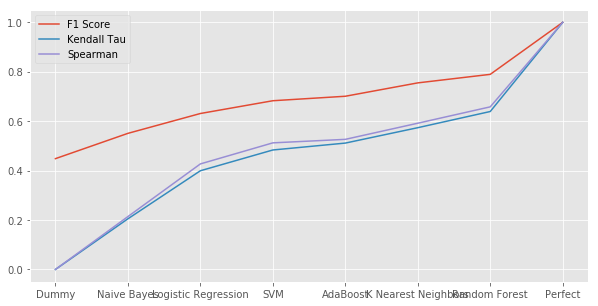

In [43]:
scores_df.sort_values('F1 score', axis='columns', inplace=True)
plt.figure(figsize = (10,5))
plt.plot(scores_df.columns.values,scores_df.loc['F1 score'].values, 
         label='F1 Score')
plt.plot(scores_df.columns.values,scores_df.loc['KendallTau'].values, 
         label='Kendall Tau')
plt.plot(scores_df.columns.values,scores_df.loc['Spearman'].values, 
         label='Spearman')
plt.legend()
plt.show()

Random Forest is a better model.

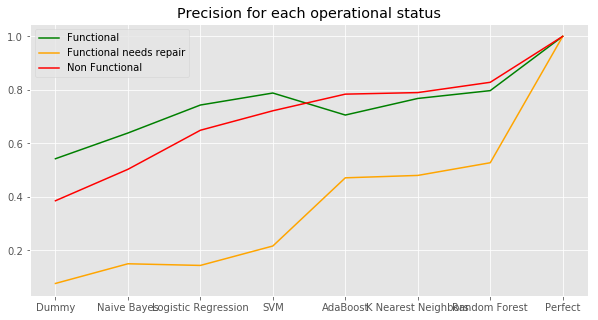

In [44]:
precision_df.sort_values('Non Functional', axis='columns', inplace=True)
plt.figure(figsize = (10,5))
plt.plot(precision_df.columns.values,precision_df.loc['Functional'].values, 
         color='green', label='Functional')
plt.plot(precision_df.columns.values,precision_df.loc['Functional needs repair'].values, 
         color = 'orange', label='Functional needs repair')
plt.plot(precision_df.columns.values,precision_df.loc['Non Functional'].values, 
         color = 'red', label='Non Functional')
plt.legend()
plt.title('Precision for each operational status')
plt.show()        

Random Forest is a better model.

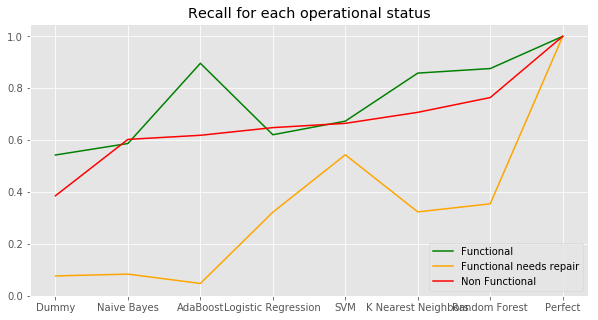

In [45]:
recall_df.sort_values('Non Functional', axis='columns', inplace=True)
plt.figure(figsize = (10,5))
plt.plot(recall_df.columns.values,recall_df.loc['Functional'].values, 
         color='green', label='Functional')
plt.plot(recall_df.columns.values,recall_df.loc['Functional needs repair'].values, 
         color = 'orange', label='Functional needs repair')
plt.plot(recall_df.columns.values,recall_df.loc['Non Functional'].values, 
         color = 'red', label='Non Functional')
plt.legend()
plt.title('Recall for each operational status')
plt.show()        

When you look at recall for each model, we see that SVM recalls better the functional needs repair water points, but its precision is not good for this label.

## Optimize the best model: Random Forest

### Display the model attributes

In [46]:
features_df = pd.DataFrame(index=list(X.columns))
i=0
features_df["average"] = 0
for estimator in rf.estimators_:
    i+=1
    features_df["Random Forest " + str(i)] = estimator.feature_importances_
    features_df["average"] += estimator.feature_importances_    
features_df["average"] /= i
print('Features importance\n')
features_df

Features importance



,average,Random Forest 1,Random Forest 2,Random Forest 3
funder,0.041379,0.038496,0.045438,0.040203
installer,0.031634,0.029980,0.034748,0.030175
basin,0.014215,0.015100,0.011339,0.016207
region,0.017357,0.017771,0.014493,0.019806
district_code,0.022019,0.020052,0.024211,0.021795
lga,0.030889,0.030373,0.029844,0.032451
ward,0.015212,0.012559,0.019280,0.013797
extraction_type_class,0.041581,0.063901,0.019852,0.040991
management,0.020215,0.021897,0.018119,0.020630
source_type,0.021723,0.023504,0.016674,0.024992


### Try to reduce the number of features to simplify the model.

public_meeting and permit have less importance

In [47]:
XR_train = X_train.drop(columns=['public_meeting','permit'])
XR_test = X_test.drop(columns=['public_meeting','permit'])

In [48]:
rf.fit(XR_train, y_train)

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=14, verbose=0, warm_start=False),
          n_jobs=None)

In [49]:
y_pred_rf = rf.predict(XR_test)
y_pred_proba_rf = rf.predict_proba(XR_test)

In [50]:
print('Scores for Random Forest with less features:\n')
scores(y_test, y_pred_rf)

Scores for Random Forest with less features:

Confusion matrix:
[[3499   92  974]
 [ 127  301  435]
 [ 596  212 5644]]

F1 score:  0.7897570959729501

 KendalltauResult(correlation=0.6426092691862154, pvalue=0.0)

 SpearmanrResult(correlation=0.6624315410308312, pvalue=0.0)


F1 score, Kendall Tau correlation and Spearman rank correlations have almost the same values. 

** Conclusion: I can get rid of the features: public_meeting and permit.**

### Use K Fold to optimize parameters

I keep XR_test, y_test as hold out, and I optimize the parameters using XR_train, y_train.

In [51]:
def fit_predict_score(XR_train, y_train, model, p, scores_df):
    """Make K folds, fit model, predict labels and returns f1 and kendall tau scores"""
    n_splits = 5
    kf = StratifiedKFold(n_splits=n_splits)
    for train_idx, test_idx in kf.split(XR_train, y_train):
        XKF_train, XKF_test = XR_train.iloc[train_idx], XR_train.iloc[test_idx]
        ykf_train, ykf_test = y_train.iloc[train_idx], y_train.iloc[test_idx]
        model.fit(XKF_train, ykf_train)
        ykf_pred = model.predict(XKF_test)
        f1 = f1_score(ykf_test, ykf_pred, average='weighted')
        kt, pval = kendalltau(ykf_test, ykf_pred)
        sr, pval = spearmanr(ykf_test, ykf_pred)
        scores_df.loc[p,'f1 score'] += f1
        scores_df.loc[p,'kendall tau'] += kt
        scores_df.loc[p,'spearman rank'] += sr
    scores_df.loc[p,'f1 score'] /= n_splits
    scores_df.loc[p,'kendall tau'] /= n_splits
    scores_df.loc[p,'spearman rank'] /= n_splits
    return scores_df

First, I will optimize n_estimators

In [52]:
n_estimators_grid = [10,50,100,150,200,300]

In [53]:
scores_df = pd.DataFrame(0, index=n_estimators_grid, columns=['f1 score','kendall tau', 'spearman rank'])
for p in n_estimators_grid:
    rf = OneVsRestClassifier(RandomForestClassifier(n_estimators=p))
    scores_df = fit_predict_score(XR_train, y_train, rf, p, scores_df)
scores_df

,f1 score,kendall tau,spearman rank
10,0.790124,0.646307,0.666139
50,0.796016,0.657747,0.677628
100,0.795963,0.656920,0.676687
150,0.796534,0.658740,0.678661
200,0.795937,0.656702,0.676368
300,0.795789,0.656765,0.676577


There is a good improvement from 10 to 50, so I choose 50 for n_estimators.

Then, I will optimize max_depth

In [54]:
max_depth_grid = [10,50,100,150,200]

In [55]:
scores_df = pd.DataFrame(0, index= max_depth_grid, columns=['f1 score','kendall tau', 'spearman rank'])
for p in max_depth_grid:
    rf = OneVsRestClassifier(RandomForestClassifier(n_estimators=50, max_depth=p))
    scores_df = fit_predict_score(XR_train, y_train, rf, p, scores_df)
scores_df

,f1 score,kendall tau,spearman rank
10,0.740867,0.591238,0.607365
50,0.795160,0.655057,0.674644
100,0.795781,0.656205,0.675803
150,0.795858,0.656612,0.676337
200,0.794686,0.654928,0.674778


There is a good improvement between 10 and 50, so I choose to use max_depth=50.

### Test the optimized model on the held out test data

In [56]:
rf = OneVsRestClassifier(RandomForestClassifier(n_estimators=50, max_depth=50))
rf.fit(XR_train, y_train)

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          n_jobs=None)

In [57]:
y_pred_rf = rf.predict(XR_test)
y_pred_proba_rf = rf.predict_proba(XR_test)

In [58]:
print('Scores for Optimized Random Forest:\n')
scores(y_test, y_pred_rf)

Scores for Optimized Random Forest:

Confusion matrix:
[[3565   73  927]
 [ 121  302  440]
 [ 580  184 5688]]

F1 score:  0.798512965263301

 KendalltauResult(correlation=0.6580983236009602, pvalue=0.0)

 SpearmanrResult(correlation=0.677230346361972, pvalue=0.0)


These are the best results I got so far!